In [1]:
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
torch.random.manual_seed(42);

# Exercise: Meta Learning

Let us consider a toy meta learning example taken from the MAML paper: regression of sinusoidal data with randomized amplitude and phases.

In [3]:
# lower and upper bounds for the sinusoidal dataset parameters
xl = -5.0
xu = 5.0
al = 0.1
au = 0.5
pl = 0.0
pu = 2 * torch.pi

In [4]:
K = 5 # K-shot regression
batch_size = 32 # meta batch size for MAML

Let us define the synthetic dataset distribution

In [5]:
def sample_datasets(batch_size, K, noise_std=0.0, return_params=False):

    """
    Sample a batch of tasks from the sine function with random phases and amplitudes.
    Each task is defined by a different amplitude and phase shift.
    """
    
    amplitudes = torch.FloatTensor(batch_size).uniform_(al, au)
    phases = torch.FloatTensor(batch_size).uniform_(pl, pu)
    batch_x = torch.FloatTensor(batch_size, K).uniform_(xl, xu)
    batch_y = amplitudes[:, None] * torch.sin(batch_x + phases[:, None])
    batch_y += torch.randn(batch_y.shape) * noise_std  # Add noise

    batch_x = batch_x[..., None]
    batch_y = batch_y[..., None]
    
    if return_params:
        # Return the parameters used to generate the tasks, useful for performance evaluation and plotting
        return batch_x, batch_y, amplitudes, phases
    else:
        # Return only the inputs and outputs
        return batch_x, batch_y


Let us sample a few "validation datasets", that we will use to evaluate the performance of MAML vs. standard initialization

In [6]:
batch_x_val, batch_y_val, amplitudes, phases = sample_datasets(batch_size=batch_size, K=K, return_params=True)

Let us visualize a few of those datasets, together with the true underlying function (which, in spirit, is assumed unknown)

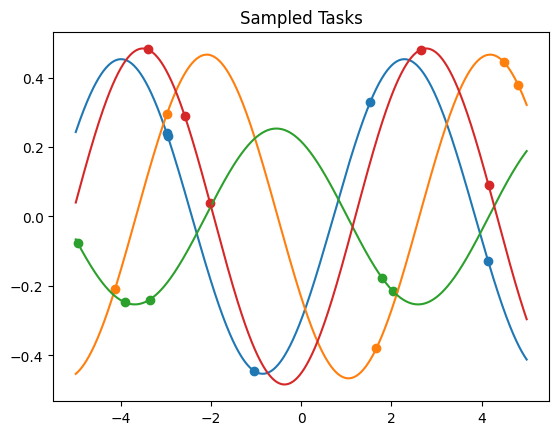

In [7]:
x_dense = torch.linspace(xl, xu, 1000)
batch_y_val_dense = amplitudes[:, None] * torch.sin(x_dense + phases[:, None])

plot_num = 4 # datasets to be visualized
plt.figure()
plt.title("Sampled Tasks")
plt.plot(batch_x_val[:plot_num, :, 0].T, batch_y_val[:plot_num, :, 0].T, 'o')
plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
plt.plot(x_dense, batch_y_val_dense[:plot_num].T);

Same datasets visualized in different subplots

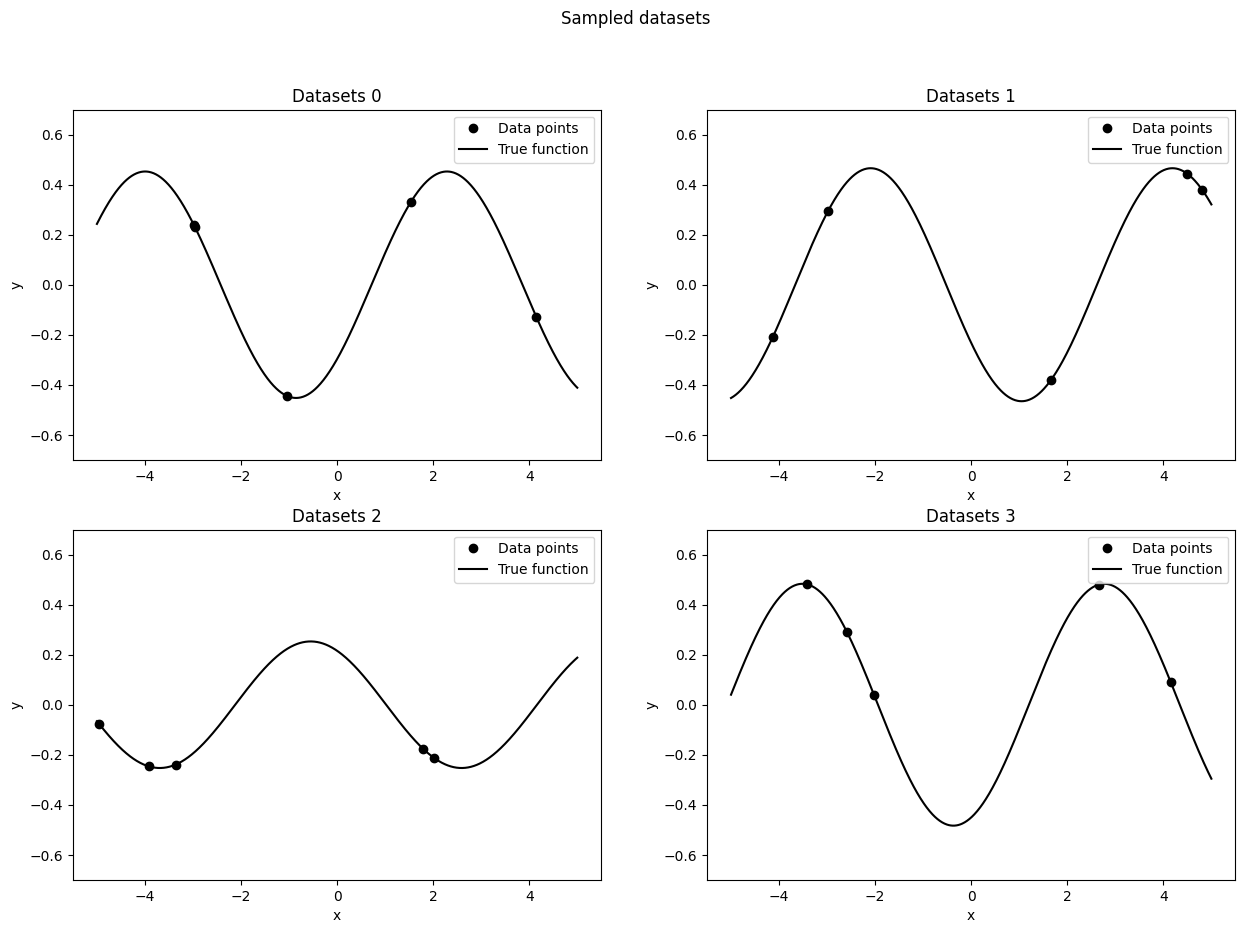

In [8]:
plot_x = 2
plot_y = 2
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Sampled datasets")
for i in range(plot_x):
    for j in range(plot_y):
        idx = i * plot_y + j
        ax[i, j].plot(batch_x_val[idx, :, 0], batch_y_val[idx, :, 0], 'ko', label='Data points')
        ax[i, j].plot(x_dense, batch_y_val_dense[idx], 'k', label='True function')
        ax[i, j].set_title(f"Datasets {idx}")
        ax[i, j].set_xlabel("x")
        ax[i, j].set_ylabel("y")
        ax[i, j].set_ylim(-.7, .7)
        ax[i, j].legend(loc='upper right')


Let us consider the following MLP model architecture, which for sure has the capacity to describe those simple 1D sinusoid functions.

In [9]:
hidden_size = 40
nx = 1
ny = 1

class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_size)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
    
mlp = MLP(hidden_size, nx, ny)

## Standard training from scratch

For (at least) one of the ``batch_size`` datasets in (`batch_x_val, batch_y_val`):

* Train an MLP model from scratch
* Evaluate the trained model against the true function (you can evaluate both on the dense grid ``x_dense``)

## In-context learning


* Train a meta model $\hat y = \mathcal{M}(D, x)$ over datasets extracted from the distribution (``sample_datasets`` function)
* Hint: adapt the code from [in_context_learning_sketch.ipynb](in_context_learning_sketch.ipynb)

## Compare In-context learning vs. standard training from scratch

For (at least) one of the ``batch_size`` datasets in (`batch_x_val, batch_y_val`):

* Apply the meta-model
* Compare the meta-model with training of an MLP from scratch

## Optional: implement MAML or a Hyper-Network

Hint: adapt the code from [maml_hypernet_sketch.ipynb](maml_hypernet_sketch.ipynb)